# 2. EDA

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import numpy as np
import pickle
from tqdm.auto import tqdm 
import umap 
from pathlib import Path
import os
from scipy.stats import linregress
from sklearn.metrics.pairwise import cosine_similarity


sns.set_theme(style="whitegrid")
plt.rcParams['axes.unicode_minus'] = False 

class Config:
    OUTPUT_PROCESSED_DATA_PATH = './dataset/processed_arxiv.pkl' 
    OUTPUT_EMBEDDING_PATH = './dataset/arxiv_embeddings_fp16.pkl'
    OUTPUT_WORD_VECTORS = './dataset/arxiv_word_vectors.pkl'
    OUTPUT_CHANGE_ANALYSIS = './dataset/arxiv_semantic_change.pkl' 
    MIN_FREQ = 1

In [13]:
try:
    df = pd.read_pickle(Config.OUTPUT_PROCESSED_DATA_PATH)
    print(f"> Final sampled data loaded successfully. Total records: {len(df)}")
    
    with open(Config.OUTPUT_EMBEDDING_PATH, 'rb') as f:
        embeddings = pickle.load(f)['emb']
    print(f"> Embeddings loaded successfully. Shape: {embeddings.shape}")
    
    if 'slot' in df.columns:
        print(f"\n--- Data Head ---\n{df[['year', 'slot', 'text']].head()}")
    else:
        print("\n[WARNING] 'slot' column not found. Please ensure preprocessing was run successfully.")

except FileNotFoundError as e:
    print(f"[Error] Required file not found. Please run the preprocessing steps first. ({e})")
    df = None
    embeddings = None

> Final sampled data loaded successfully. Total records: 3500
> Embeddings loaded successfully. Shape: torch.Size([3500, 768])

--- Data Head ---
   year       slot                                               text
0  1991  1991-1995  Evanescent Black Holes   A renormalizable theo...
1  1991  1991-1995  Collective Field Representation of Nonrelativi...
2  1991  1991-1995  Ground Rings and Their Modules in 2D Gravity w...
3  1991  1991-1995  Comments on Supersymmetric Vector and Matrix M...
4  1991  1991-1995  On the connection between Quantum Mechanics an...


## 2.1. 시기별 데이터 분포 확인

## 2.1.1. 슬롯별 논문 개수 시각화 


/var/folders/tg/v_32vyl14g5dm3wm3452sjrc0000gn/T/ipykernel_22937/1040757994.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=slot_counts.index, y=slot_counts.values, palette="viridis")


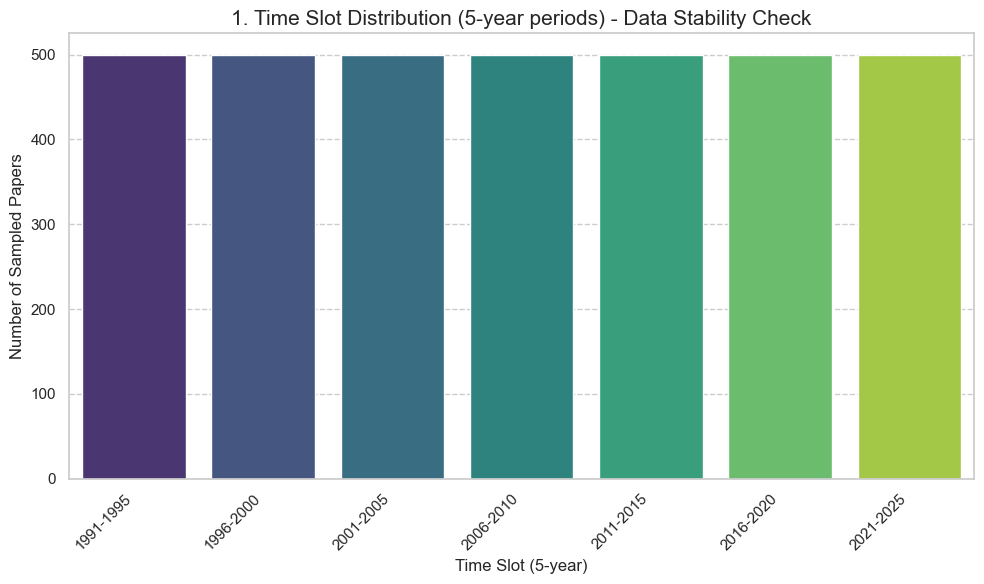


[Check Point] Slot Count:
slot
1991-1995    500
1996-2000    500
2001-2005    500
2006-2010    500
2011-2015    500
2016-2020    500
2021-2025    500


In [14]:
slot_counts = df['slot'].value_counts().sort_index()
    
plt.figure(figsize=(10, 6))
# '1991-1995', '1996-2000' 형태의 슬롯이 출력됩니다.
sns.barplot(x=slot_counts.index, y=slot_counts.values, palette="viridis")
plt.title('1. Time Slot Distribution (5-year periods) - Data Stability Check', fontsize=15)
plt.xlabel('Time Slot (5-year)', fontsize=12)
plt.ylabel('Number of Sampled Papers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

print(f"\n[Check Point] Slot Count:\n{slot_counts.to_string()}")

## 2.2. 차원 축소 및 초기 경향성 시각화

-> 오래된 슬롯(예: 1991-1995)과 최신 슬롯(예: 2021-2025)의 클러스터가 시각적으로 분리되는지 확인
-> **AutoML (Optuna)** 튜닝을 위한 n_neighbors 범위 후보를 설정하는 데 사용됩니다.  

> Starting UMAP 2D Projection for Visual EDA...
UMAP(n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Tue Dec  9 00:11:16 2025 Construct fuzzy simplicial set


/Users/minseokim/miniconda/envs/kaggle/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Tue Dec  9 00:11:19 2025 Finding Nearest Neighbors
Tue Dec  9 00:11:20 2025 Finished Nearest Neighbor Search
Tue Dec  9 00:11:20 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Dec  9 00:11:23 2025 Finished embedding
CPU times: user 7.28 s, sys: 74.3 ms, total: 7.35 s
Wall time: 7.36 s


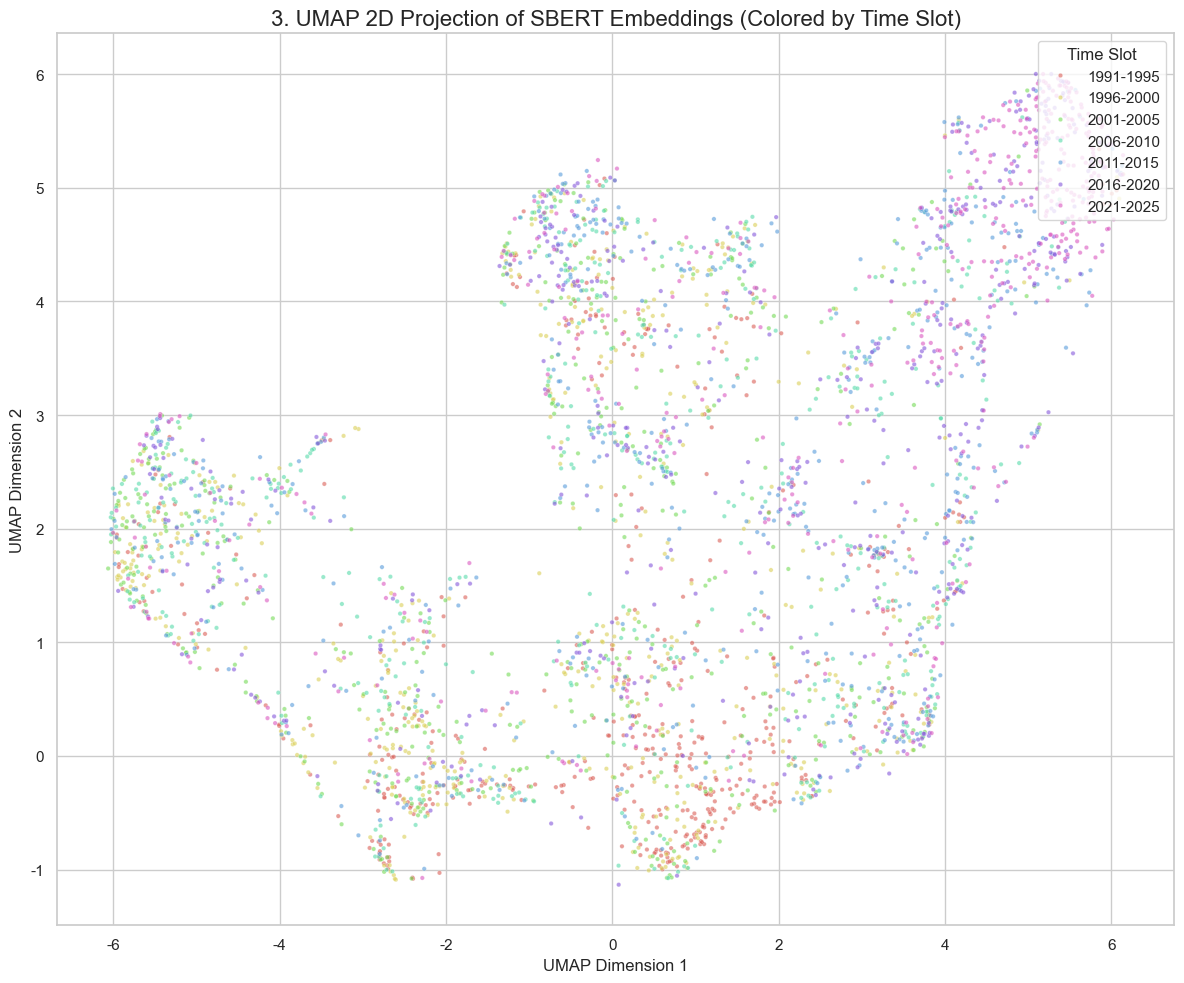


[Check Point] UMAP 2D Projection Complete.


In [15]:
print("> Starting UMAP 2D Projection for Visual EDA...")

# UMAP 초기 설정 (AutoML n_neighbors 범위 설정을 위한 초기값 사용)
umap_reducer = umap.UMAP(
    n_neighbors=30, # default 15에서 약간 증가시켜 전역 구조 포착 시도
    min_dist=0.1,
    n_components=2,
    random_state=42,
    verbose=True
)

# 임베딩 투영
%time projected_embeddings = umap_reducer.fit_transform(embeddings)

df_proj = pd.DataFrame(projected_embeddings, columns=['UMAP_X', 'UMAP_Y'])
# 인덱스가 맞도록 reset_index(drop=True)를 사용하여 'slot' 컬럼 추가
df_proj['slot'] = df['slot'].reset_index(drop=True) 

# 시각화
plt.figure(figsize=(12, 10))
# 슬롯별 색상 구분
sns.scatterplot(
    x='UMAP_X', 
    y='UMAP_Y', 
    hue='slot', 
    data=df_proj, 
    palette=sns.color_palette("hls", len(df_proj['slot'].unique())),
    s=10, 
    alpha=0.6
)
plt.title('3. UMAP 2D Projection of SBERT Embeddings (Colored by Time Slot)', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.legend(title='Time Slot', loc='upper right')
plt.tight_layout()
plt.show()

    
print("\n[Check Point] UMAP 2D Projection Complete.")

## 2.3. 단어 빈도 분석 및 $\text{min\_freq}$ 설정

### 2.3.1. Stop word 필터링 

In [16]:
import nltk
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')

from nltk.corpus import stopwords
ENGLISH_STOPWORDS = set(stopwords.words('english'))

def simple_tokenize(text, stopwords_set=ENGLISH_STOPWORDS):
    text = str(text).lower()
    
    # 1. 토큰화 (3글자 이상 알파벳)
    tokens = re.findall(r'\b[a-z]{3,}\b', text)
    
    # 2. 불용어 필터링
    filtered_tokens = [word for word in tokens if word not in stopwords_set]
    
    return filtered_tokens

### 2.3.2. 전체 텍스트 기반 단어 빈도 분포 확인 (Zipf의 법칙 경향성)

> Starting tokenization for Word Frequency Analysis...


Tokenizing:   0%|          | 0/3500 [00:00<?, ?it/s]

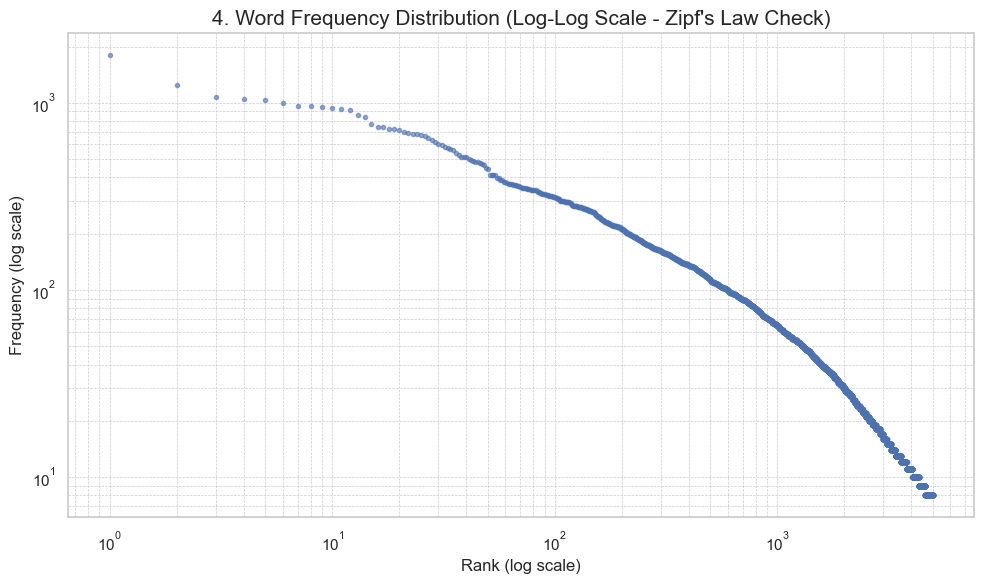

In [17]:
all_tokens = []
print("> Starting tokenization for Word Frequency Analysis...")

for text in tqdm(df['text'].tolist(), desc="Tokenizing"): 
    all_tokens.extend(simple_tokenize(text))
    
word_counts = Counter(all_tokens)

top_n = 5000
sorted_counts = pd.Series(dict(word_counts.most_common(top_n))).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_counts) + 1), sorted_counts.values, marker='.', linestyle='', alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.title('4. Word Frequency Distribution (Log-Log Scale - Zipf\'s Law Check)', fontsize=15)
plt.xlabel('Rank (log scale)', fontsize=12)
plt.ylabel('Frequency (log scale)', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

### 2.3.3. Min_Freq 후보군 설정 (가장 오래된 슬롯 기준)

In [18]:
oldest_slot = df['slot'].min()
if oldest_slot:
    print(f"\n> Determining min_freq candidate based on the oldest slot: {oldest_slot}")
    
    df_oldest = df[df['slot'] == oldest_slot]
    oldest_tokens = []
    for text in df_oldest['text'].tolist():
        oldest_tokens.extend(simple_tokenize(text))
    
    oldest_word_counts = Counter(oldest_tokens)
    
    # min_freq=100을 만족하는 단어 개수 확인
    count_at_min_freq = sum(1 for count in oldest_word_counts.values() if count >= Config.MIN_FREQ)
    
    print(f">> Total unique words in {oldest_slot}: {len(oldest_word_counts)}")
    print(f">> Number of words with Frequency >= {Config.MIN_FREQ} in {oldest_slot}: {count_at_min_freq} words")


> Determining min_freq candidate based on the oldest slot: 1991-1995
>> Total unique words in 1991-1995: 5168
>> Number of words with Frequency >= 1 in 1991-1995: 5168 words


---

# Word Vector Approximation

In [19]:
def get_word_vector_approximation(df, embeddings, min_freq=Config.MIN_FREQ):
    """
    각 Time Slot별로 최소 빈도를 만족하는 단어들의 벡터를 문장 임베딩의 평균으로 근사합니다.
    """
    
    # # 1. 캐시 확인 및 로드
    # if Path(Config.OUTPUT_WORD_VECTORS).exists():
    #     print(f"> Word vector cache found. Loading from: {Config.OUTPUT_WORD_VECTORS}")
    #     with open(Config.OUTPUT_WORD_VECTORS, 'rb') as f:
    #         word_vectors_by_slot = pickle.load(f)
    #     print(f"> Successfully loaded word vectors for {len(word_vectors_by_slot)} slots.")
    #     return word_vectors_by_slot
    
    print(f"> Cache not found. Starting Word Vector Approximation (MIN_FREQ={min_freq})...")
    
    print("> Converting embeddings to a single NumPy array for WVA stability...")
    if isinstance(embeddings, list):
        # embeddings가 리스트 안에 여러 텐서/배열로 되어 있다면, np.concatenate로 합칩니다.
        embeddings = np.concatenate(embeddings, axis=0)
    elif hasattr(embeddings, 'numpy'):
        # PyTorch 텐서일 경우
        embeddings = embeddings.cpu().numpy()
    
    # 임베딩이 딕셔너리로 로드된 경우 (이전 에러 해결)
    if isinstance(embeddings, dict) and 'emb' in embeddings:
            embeddings = embeddings['emb']

    # 최종적으로 np.ndarray가 아니면 오류 발생
    if not isinstance(embeddings, np.ndarray):
            raise TypeError("Final embeddings variable is not a NumPy array.")
            
    print(f"> Conversion successful. New embeddings shape: {embeddings.shape}")

    # 인덱스 일관성 확인 (DataFrame 인덱스를 NumPy 배열 인덱스와 일치시키기 위해)
    df = df.reset_index(drop=True)
    
    slots = sorted(df['slot'].unique())
    word_vectors_by_slot = {}
    
    total_words_processed = 0

    for slot in tqdm(slots, desc="Processing Slots"):
        slot_df = df[df['slot'] == slot].copy()
        
        # 해당 Slot의 임베딩 추출
        slot_indices = slot_df.index.tolist()
        slot_embeddings = embeddings[slot_indices]
        
        # 2. 토큰화 및 빈도 계산
        slot_df['tokens'] = slot_df['text'].apply(simple_tokenize)
        all_tokens = [token for sublist in slot_df['tokens'] for token in sublist]
        word_counts = Counter(all_tokens)
        
        # 최소 빈도 만족 단어 필터링
        target_words = {word for word, count in word_counts.items() if count >= min_freq}
        
        if not target_words:
            print(f"\n[Warning] Slot {slot}: No words met the MIN_FREQ={min_freq} criterion. Skipping.")
            continue
            
        slot_word_vectors = {}
        
        # 3. 단어 벡터 근사치 계산 (문장 임베딩 평균)
        for word in target_words:
            # 해당 단어를 포함하는 문서의 인덱스 찾기
            doc_indices_in_slot = slot_df.index[
                slot_df['tokens'].apply(lambda tokens: word in tokens)
            ].tolist()
            
            if not doc_indices_in_slot:
                # MIN_FREQ 필터링 후에도 (이론적으로 발생하지 않아야 함) 문서가 없으면 건너뛰기
                continue
            
            # 단어를 포함하는 문서의 임베딩 추출 및 평균 계산
            word_embedding_sum = np.zeros(embeddings.shape[1], dtype=np.float32)
            
            # 주의: df의 인덱스(doc_indices_in_slot)는 embeddings 배열의 인덱스와 직접 매칭됨
            # 해당 단어가 포함된 모든 문서의 임베딩을 합산
            for idx in doc_indices_in_slot:
                 word_embedding_sum += embeddings[idx]

            # 평균 계산 (Word Vector Approximation)
            avg_vector = word_embedding_sum / len(doc_indices_in_slot)
            
            slot_word_vectors[word] = avg_vector
            total_words_processed += 1
            
        word_vectors_by_slot[slot] = slot_word_vectors
        print(f"\n> Slot {slot} processed. Found {len(slot_word_vectors)} target words.")

    # 4. 결과 캐시 저장
    Path(os.path.dirname(Config.OUTPUT_WORD_VECTORS)).mkdir(parents=True, exist_ok=True)
    with open(Config.OUTPUT_WORD_VECTORS, 'wb') as f:
        pickle.dump(word_vectors_by_slot, f)
        
    print(f"\n--- WVA Complete ---")
    print(f"Total slots processed: {len(word_vectors_by_slot)}")
    print(f"Total unique word vectors created across all slots: {total_words_processed}")
    
    return word_vectors_by_slot

In [20]:
word_vectors = get_word_vector_approximation(df, embeddings)

> Cache not found. Starting Word Vector Approximation (MIN_FREQ=1)...
> Converting embeddings to a single NumPy array for WVA stability...
> Conversion successful. New embeddings shape: (3500, 768)


Processing Slots:   0%|          | 0/7 [00:00<?, ?it/s]


> Slot 1991-1995 processed. Found 5168 target words.

> Slot 1996-2000 processed. Found 5937 target words.

> Slot 2001-2005 processed. Found 6210 target words.

> Slot 2006-2010 processed. Found 6998 target words.

> Slot 2011-2015 processed. Found 7397 target words.

> Slot 2016-2020 processed. Found 8125 target words.

> Slot 2021-2025 processed. Found 8478 target words.

--- WVA Complete ---
Total slots processed: 7
Total unique word vectors created across all slots: 48313


# 3. 의미 변화율 계산 (Semantic Change Calculation)

In [21]:

# --- 단어 벡터 및 데이터 로드 ---
try:
    with open(Config.OUTPUT_WORD_VECTORS, 'rb') as f:
        word_vectors = pickle.load(f)
    print(f"> Word vectors loaded for {len(word_vectors)} slots.")
    
    # 원본 df 로드 (총 빈도 계산을 위해)
    df = pd.read_pickle(Config.OUTPUT_PROCESSED_DATA_PATH) 
    
except FileNotFoundError as e:
    print(f"[Error] Required file not found. Please run WVA (Cell 6) first. ({e})")
    word_vectors = None
    df = None


if word_vectors:

    # 1. 슬롯 정렬 및 공통 단어 추출
    slots = sorted(word_vectors.keys())
    
    if len(slots) < 2:
        print("[Error] Not enough time slots for diachronic analysis.")
        exit()

    # 모든 슬롯에 등장하는 단어의 교집합 (안정적인 분석을 위해)
    common_words = set.intersection(*(set(word_vectors[s].keys()) for s in slots))
    print(f"> Found {len(common_words)} common words across all slots (MIN_FREQ={Config.MIN_FREQ}).")

    if not common_words:
        print("[Error] No common words found across all slots. Try lowering MIN_FREQ.")
        exit()

    # 2. 단어 벡터 매트릭스 준비
    # 단어(행) x 임베딩 차원(열) x 슬롯(깊이) 형태의 3D 배열
    common_word_list = sorted(list(common_words))
    vector_dim = list(word_vectors.values())[0][common_word_list[0]].shape[0]
    T = len(slots)
    
    # [단어 개수, 임베딩 차원, 시간 슬롯 개수]
    vector_matrix = np.zeros((len(common_word_list), vector_dim, T), dtype=np.float32)
    
    for t_idx, slot in enumerate(slots):
        for w_idx, word in enumerate(common_word_list):
            vector_matrix[w_idx, :, t_idx] = word_vectors[slot][word]

    # 3. 시기별 의미 변화율 (Change Rate) 계산
    change_rates = {} # {word: change_rate_value}
    
    # (T-1)개의 변화 시점
    num_transitions = T - 1 

    for w_idx, word in tqdm(enumerate(common_word_list), total=len(common_word_list), desc="Calculating Change Rate"):
        
        # 시점 t에서 t+1로의 변화율을 합산
        total_similarity = 0
        
        # 0 ~ T-2 까지 반복 (t_idx와 t_idx+1 비교)
        for t_idx in range(num_transitions):
            v_t = vector_matrix[w_idx, :, t_idx].reshape(1, -1)
            v_t_plus_1 = vector_matrix[w_idx, :, t_idx + 1].reshape(1, -1)
            
            # 코사인 유사도
            similarity = cosine_similarity(v_t, v_t_plus_1)[0, 0]
            total_similarity += similarity
        
        # 평균 변화율 (1 - 평균 유사도) 계산
        avg_similarity = total_similarity / num_transitions
        change_rate = 1 - avg_similarity
        
        change_rates[word] = change_rate

    # 4. 전체 기간 동안의 단어 빈도 계산
    all_tokens_combined = []
    # simple_tokenize 함수는 Cell 6에서 정의된 Stop Word 제거 버전 사용
    for text in tqdm(df['text'].tolist(), desc="Calculating Total Frequency"):
        all_tokens_combined.extend(simple_tokenize(text))
        
    word_counts = Counter(all_tokens_combined)
    total_frequencies = {word: word_counts[word] for word in common_words}
    
    # 5. Law of Conformity 분석 데이터 프레임 생성
    analysis_data = []
    for word in common_words:
        analysis_data.append({
            'word': word,
            'change_rate': change_rates[word],
            'frequency': total_frequencies[word]
        })

    df_analysis = pd.DataFrame(analysis_data)
    
    # Log 변환 (Law of Conformity 검증을 위해)
    df_analysis['log_frequency'] = np.log(df_analysis['frequency'])
    # 변화율이 0인 경우를 방지하기 위해 매우 작은 값(1e-10)을 더함
    df_analysis['log_change_rate'] = np.log(df_analysis['change_rate'] + 1e-10) 
    
    # 6. 결과 캐시 저장
    Path(os.path.dirname(Config.OUTPUT_CHANGE_ANALYSIS)).mkdir(parents=True, exist_ok=True)
    with open(Config.OUTPUT_CHANGE_ANALYSIS, 'wb') as f:
        pickle.dump(df_analysis, f)
        
    print(f"\n--- Semantic Change Calculation Complete ---")
    print(f"Analysis data saved with {len(df_analysis)} words.")

> Word vectors loaded for 7 slots.
> Found 2040 common words across all slots (MIN_FREQ=1).


Calculating Change Rate:   0%|          | 0/2040 [00:00<?, ?it/s]

Calculating Total Frequency:   0%|          | 0/3500 [00:00<?, ?it/s]


--- Semantic Change Calculation Complete ---
Analysis data saved with 2040 words.



--- Law of Conformity Regression Results ---
Slope (Inverse Power-Law Exponent, -α): -0.4941
R-squared (R^2): 0.7246
P-value: 0.0000

[Conclusion] The Law of Conformity is supported (p-value < 0.05, negative slope).


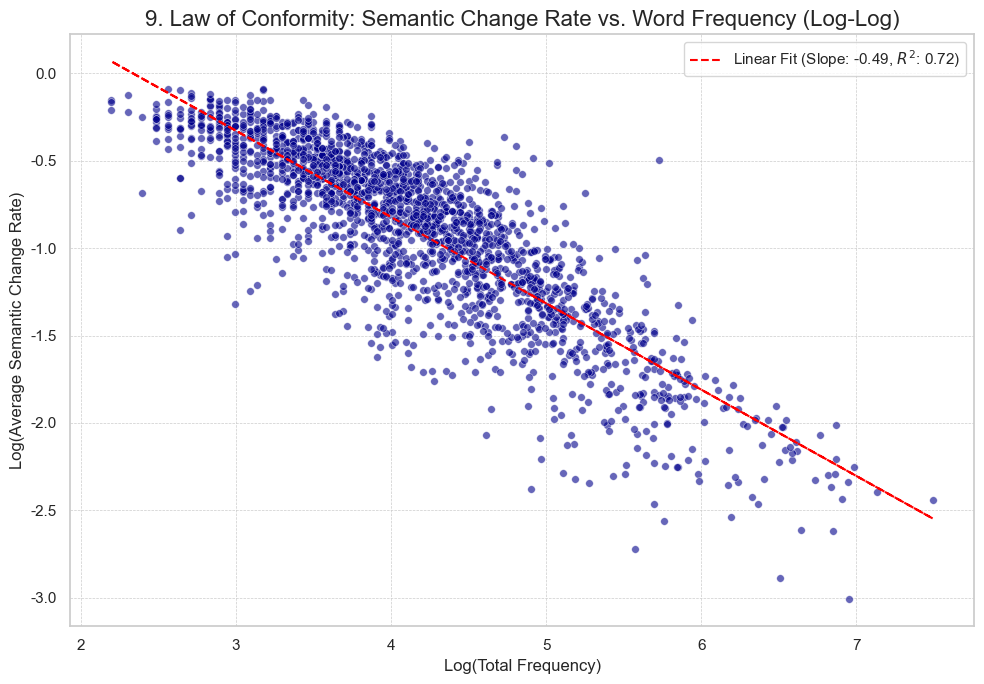


--- Top 10 Most Changing Words (High Change Rate) ---
       word  change_rate  frequency
  resources     0.916099         24
    closure     0.914205         13
     shapes     0.910516         24
    changed     0.909109         14
concentrate     0.893953         15
    counter     0.887430         17
   valuable     0.886595         22
    centers     0.882596         10
     freely     0.881193         15
      today     0.870430         15

--- Top 10 Least Changing Words (Low Change Rate) ---
    word  change_rate  frequency
   model     0.087005       1796
   stars     0.085290        298
   phase     0.085135        581
  states     0.078992        490
galaxies     0.077213        318
  energy     0.073308        767
  theory     0.072968        941
  galaxy     0.065688        263
    mass     0.055582        671
 quantum     0.049334       1048


In [22]:
# ==============================================================================
# 8. Law of Conformity 검증 및 시각화 (Final Step)
# ==============================================================================

if 'df_analysis' in locals():
    
    # 1. 선형 회귀 분석 (Law of Conformity 검증)
    # Law: log(ChangeRate) ∝ -α * log(Frequency)
    slope, intercept, r_value, p_value, std_err = linregress(
        df_analysis['log_frequency'], 
        df_analysis['log_change_rate']
    )
    
    print("\n--- Law of Conformity Regression Results ---")
    print(f"Slope (Inverse Power-Law Exponent, -α): {slope:.4f}")
    print(f"R-squared (R^2): {r_value**2:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05 and slope < 0:
        print(f"\n[Conclusion] The Law of Conformity is supported (p-value < 0.05, negative slope).")
    else:
        print(f"\n[Conclusion] The Law of Conformity is NOT strongly supported by this dataset.")

    # 2. 시각화
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x='log_frequency', 
        y='log_change_rate', 
        data=df_analysis, 
        alpha=0.6,
        s=30,
        color='darkblue'
    )
    
    # 회귀선 추가
    plt.plot(
        df_analysis['log_frequency'], 
        intercept + slope * df_analysis['log_frequency'], 
        color='red', 
        linestyle='--', 
        label=f'Linear Fit (Slope: {slope:.2f}, $R^2$: {r_value**2:.2f})'
    )
    
    plt.title('9. Law of Conformity: Semantic Change Rate vs. Word Frequency (Log-Log)', fontsize=16)
    plt.xlabel('Log(Total Frequency)', fontsize=12)
    plt.ylabel('Log(Average Semantic Change Rate)', fontsize=12)
    plt.legend()
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

    

    # 3. 가장 변화가 큰/작은 단어 확인 (추가 EDA)
    df_sorted_change = df_analysis.sort_values(by='change_rate', ascending=False)
    print("\n--- Top 10 Most Changing Words (High Change Rate) ---")
    print(df_sorted_change[['word', 'change_rate', 'frequency']].head(10).to_string(index=False))

    print("\n--- Top 10 Least Changing Words (Low Change Rate) ---")
    print(df_sorted_change[['word', 'change_rate', 'frequency']].tail(10).to_string(index=False))

else:
    print("WARNING: df_analysis variable not found. Please run Cell 7 first.")

---